In [1]:
"""
Cell 1: Import Libraries và Configuration
DDPG cho HVAC Control
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pyfmi import load_fmu
from collections import deque
import random
import os
from datetime import datetime
import json

# Thiết lập seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU available: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("✓ Running on CPU")

print("TensorFlow version:", tf.__version__)
print("✓ All libraries imported successfully")


✓ Running on CPU
TensorFlow version: 2.20.0
✓ All libraries imported successfully


In [2]:
"""
Cell 2: DDPG Components - Replay Buffer và OU Noise
"""

class ReplayBuffer:
    """Replay Buffer cho DDPG"""
    def __init__(self, buffer_capacity=50000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0
        
        self.state_buffer = deque(maxlen=buffer_capacity)
        self.action_buffer = deque(maxlen=buffer_capacity)
        self.reward_buffer = deque(maxlen=buffer_capacity)
        self.next_state_buffer = deque(maxlen=buffer_capacity)
        self.done_buffer = deque(maxlen=buffer_capacity)
    
    def record(self, obs_tuple):
        state, action, reward, next_state, done = obs_tuple
        self.state_buffer.append(state)
        self.action_buffer.append(action)
        self.reward_buffer.append(reward)
        self.next_state_buffer.append(next_state)
        self.done_buffer.append(done)
        self.buffer_counter += 1
    
    def record_batch(self, states, actions, rewards, next_states, dones):
        """Lưu toàn bộ batch vào buffer"""
        for i in range(len(states)):
            self.record((states[i], actions[i], rewards[i], next_states[i], dones[i]))
    
    def sample_batch(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        
        state_batch = np.array([self.state_buffer[i] for i in batch_indices])
        action_batch = np.array([self.action_buffer[i] for i in batch_indices])
        reward_batch = np.array([self.reward_buffer[i] for i in batch_indices])
        next_state_batch = np.array([self.next_state_buffer[i] for i in batch_indices])
        done_batch = np.array([self.done_buffer[i] for i in batch_indices])
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return min(self.buffer_counter, self.buffer_capacity)
    
    def is_ready(self):
        return len(self) >= self.batch_size


class OUActionNoise:
    """Ornstein-Uhlenbeck Noise cho exploration"""
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


print("✓ ReplayBuffer and OUActionNoise classes defined")


✓ ReplayBuffer and OUActionNoise classes defined


In [3]:
"""
Cell 3: HVAC Environment - Timestep 900s, Occupancy Random
"""

class HVACEnvironment:
    """
    HVAC Environment cho DDPG với Reward Function theo specification
    - Timestep: 900s (15 phút)
    - uFan = 0.6 (LOCKED)
    - uFanEA = 0.3 (LOCKED)
    - Occupancy: Random, KHÔNG được điều khiển bởi agent
    - State: [T_zone, RH_zone, CO2_zone, T_outdoor, RH_outdoor, hour, day, occupancy]
    - Action: [uOA, uChiller, uHeater] - CHỈ 3 chiều
    """
    
    def __init__(self, fmu_path, weather_csv_path, simulation_days=60):
        self.fmu_path = fmu_path
        self.weather_csv_path = weather_csv_path
        self.simulation_days = simulation_days
        
        # Load weather data
        print("=== Đọc dữ liệu thời tiết ===")
        self.weather_df = pd.read_csv(weather_csv_path)
        print(f"Weather data: {len(self.weather_df)} timesteps")
        print(f"Thời gian: {self.weather_df['time'].min()}s đến {self.weather_df['time'].max()}s")
        print(f"Độ dài: {(self.weather_df['time'].max()-self.weather_df['time'].min())/3600:.1f} giờ\n")
        
        # ===== TIMESTEP = 900s (15 phút) =====
        self.dt = 900.0  # seconds
        self.start_time = 0.0
        self.final_time = simulation_days * 24 * 3600
        
        # Số steps = số timesteps 900s
        self.n_steps = int(self.final_time / self.dt)  # 60 days * 96 steps/day = 5760 steps
        
        # Tạo time array cho 900s timesteps
        self.time_array = np.arange(0, self.final_time + self.dt, self.dt)
        
        # State và Action dimensions
        self.state_dim = 8  # Thêm occupancy vào state
        self.action_dim = 3  # CHỈ [uOA, uChiller, uHeater]
        
        # Action bounds - uOA: [0.5-0.8], others: [0-1]
        self.action_low = np.array([0.5, 0.0, 0.0])
        self.action_high = np.array([0.8, 1.0, 1.0])
        
        # LOCKED control values
        self.uFan = 0.6
        self.uFanEA = 0.3
        
        # ======= REWARD FUNCTION PARAMETERS =======
        self.beta_T_high = 28.0  # °C
        self.beta_T_low = 25.5   # °C
        self.beta_RH = 0.60  # 60%
        self.beta_CO2 = 1000.0  # ppm
        self.beta_CO2_scale = 500.0
        
        # Điều chỉnh coefficients để penalize nhiệt độ cao hơn
        self.alpha_E = 0.25      # Giảm energy penalty
        self.alpha_T = 0.35      # TĂNG temperature penalty
        self.alpha_RH = 0.25     # Giảm RH penalty
        self.alpha_CO2 = 0.10    # Giảm CO2 penalty
        self.alpha_smooth = 0.05
        
        print(f"✓ HVAC Environment initialized")
        print(f"  - Simulation: {simulation_days} days = {self.n_steps} steps")
        print(f"  - Timestep: {self.dt}s (15 min)")
        print(f"  - State dim: {self.state_dim}, Action dim: {self.action_dim}")
        print(f"  - uFan: {self.uFan} (LOCKED), uFanEA: {self.uFanEA} (LOCKED)")
        print(f"  - Occupancy: RANDOM (0-1, step 0.1) - NOT controlled by agent")
        print(f"\n  Reward Parameters:")
        print(f"  - T comfort: [{self.beta_T_low}, {self.beta_T_high}]°C")
        print(f"  - Coefficients: αE={self.alpha_E}, αT={self.alpha_T} (INCREASED)")
    
    def reset(self):
        """Reset environment"""
        initial_weather = {
            'TDryBul': self.weather_df.loc[0, 'TDryBul'],
            'relHum': self.weather_df.loc[0, 'relHum']
        }
        
        # Random initial occupancy
        initial_occ = np.random.choice([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        
        state = np.array([
            25.0,  # T_zone (°C)
            50.0,  # RH_zone (%)
            400.0,  # CO2_zone (ppm)
            initial_weather['TDryBul'] - 273.15,
            initial_weather['relHum'] * 100,
            0.0,   # hour
            0.0,   # day
            initial_occ  # occupancy
        ], dtype=np.float32)
        
        return state
    
    def generate_occupancy_schedule(self, n_steps):
        """
        Generate random occupancy schedule
        Returns: array of shape (n_steps,) with values in {0, 0.1, 0.2, ..., 1.0}
        """
        occupancy_values = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        occupancy_schedule = np.random.choice(occupancy_values, size=n_steps)
        return occupancy_schedule
    
    def compute_reward(self, T_zone_K, RH_zone_frac, CO2_zone_ppm, P_total_W, 
                       action, prev_action, occupancy):
        """
        Compute reward - occupancy là input, không phải action
        """
        # Convert units
        T_zone_C = T_zone_K - 273.15
        RH_zone = RH_zone_frac
        P_total_kW = P_total_W / 1000.0
        
        # ===== ENERGY PENALTY =====
        R_energy = P_total_kW / 20.0
        
        # ===== TEMPERATURE PENALTY (ENHANCED) =====
        # Penalty lũy thừa cho nhiệt độ quá cao/thấp
        if T_zone_C > self.beta_T_high:
            deviation = (T_zone_C - self.beta_T_high)
            f_T = deviation ** 1.5  # Lũy thừa để penalty mạnh hơn
        elif T_zone_C < self.beta_T_low:
            deviation = (self.beta_T_low - T_zone_C)
            f_T = deviation ** 1.5
        else:
            f_T = 0.0
        
        # ===== HUMIDITY PENALTY =====
        if RH_zone > self.beta_RH:
            f_RH = (RH_zone - self.beta_RH)
        else:
            f_RH = 0.0
        
        # ===== CO2 PENALTY =====
        if CO2_zone_ppm > self.beta_CO2:
            f_CO2 = (CO2_zone_ppm - self.beta_CO2) / self.beta_CO2_scale
        else:
            f_CO2 = 0.0
        
        # ===== SMOOTHNESS PENALTY =====
        if prev_action is not None:
            action_denorm = action * (self.action_high - self.action_low) + self.action_low
            prev_action_denorm = prev_action * (self.action_high - self.action_low) + self.action_low
            
            delta_uOA = action_denorm[0] - prev_action_denorm[0]
            delta_uChiller = action_denorm[1] - prev_action_denorm[1]
            delta_uHeater = action_denorm[2] - prev_action_denorm[2]
            
            f_smooth = (delta_uOA)**2 + (delta_uChiller)**2 + (delta_uHeater)**2
        else:
            f_smooth = 0.0
        
        # ===== TOTAL REWARD =====
        reward = -(
            self.alpha_E * R_energy +
            self.alpha_T * f_T +       # Temperature penalty mạnh hơn
            self.alpha_RH * f_RH +
            self.alpha_CO2 * f_CO2 +
            self.alpha_smooth * f_smooth
        )
        
        # Chỉ áp dụng comfort penalties khi occupied (occupancy > 0.3)
        if occupancy < 0.3:
            reward = -(self.alpha_E * R_energy + self.alpha_smooth * f_smooth)
        
        return reward
    
    def run_episode_simulation(self, episode_actions, occupancy_schedule):
        """
        Chạy FMU simulation - timestep 900s
        Args:
            episode_actions: (n_steps, 3) - [uOA, uChiller, uHeater]
            occupancy_schedule: (n_steps,) - random occupancy
        """
        print(f"\n🔄 Running FMU simulation ({self.simulation_days} days, timestep={self.dt}s)...")
        
        n_points = len(self.time_array)
        
        # Weather inputs - interpolate hourly data to 900s timesteps
        weather_input_names = ['TDryBul', 'relHum', 'pAtm', 'winSpe', 'HDirNor', 'HDifHor']
        
        # Interpolate weather từ hourly data
        weather_time_hourly = self.weather_df['time'].values
        weather_data_interp = np.column_stack([
            np.interp(self.time_array, weather_time_hourly, self.weather_df['TDryBul'].values),
            np.interp(self.time_array, weather_time_hourly, self.weather_df['relHum'].values),
            np.interp(self.time_array, weather_time_hourly, self.weather_df['pAtm'].values),
            np.interp(self.time_array, weather_time_hourly, self.weather_df['winSpe'].values),
            np.interp(self.time_array, weather_time_hourly, self.weather_df['HGloHor'].values),
            np.interp(self.time_array, weather_time_hourly, self.weather_df['HDifHor'].values)
        ])
        
        # Extend actions if needed
        if len(episode_actions) < n_points:
            pad_length = n_points - len(episode_actions)
            last_action = episode_actions[-1:].repeat(pad_length, axis=0)
            episode_actions_full = np.vstack([episode_actions, last_action])
        else:
            episode_actions_full = episode_actions[:n_points]
        
        # Extend occupancy
        if len(occupancy_schedule) < n_points:
            pad_length = n_points - len(occupancy_schedule)
            last_occ = np.repeat(occupancy_schedule[-1], pad_length)
            occupancy_full = np.concatenate([occupancy_schedule, last_occ])
        else:
            occupancy_full = occupancy_schedule[:n_points]
        
        # Denormalize actions
        episode_actions_denorm = episode_actions_full * (self.action_high - self.action_low) + self.action_low
        
        # Control inputs
        control_input_names = ['uFan', 'uOA', 'uChiller', 'uHeater', 'occupancy', 'uFanEA']
        
        control_data = np.column_stack([
            self.uFan * np.ones(n_points),
            episode_actions_denorm[:, 0],  # uOA
            episode_actions_denorm[:, 1],  # uChiller
            episode_actions_denorm[:, 2],  # uHeater
            occupancy_full,                # Random occupancy
            self.uFanEA * np.ones(n_points)
        ])
        
        # Combine inputs
        input_data = np.column_stack([self.time_array, weather_data_interp, control_data])
        input_object = (weather_input_names + control_input_names, input_data)
        
        print(f"  Input shape: {input_data.shape}")
        print(f"  Time range: {self.time_array[0]:.0f}s to {self.time_array[-1]:.0f}s")
        print(f"  Occupancy range: [{occupancy_full.min():.1f}, {occupancy_full.max():.1f}]")
        
        # Load FMU
        try:
            model = load_fmu(self.fmu_path)
            print(f"  ✓ FMU loaded: {model.get_name()}")
        except Exception as e:
            print(f"  ✗ FMU load error: {e}")
            return None, None, None
        
        # Simulation options
        opts = model.simulate_options()
        opts['ncp'] = n_points  # Output points = input points
        opts['CVode_options']['rtol'] = 1e-5
        opts['CVode_options']['atol'] = 1e-5
        
        try:
            res = model.simulate(
                start_time=self.start_time,
                final_time=self.final_time,
                input=input_object,
                options=opts
            )
            print("  ✓ Simulation thành công!")
        except Exception as e:
            print(f"  ✗ Simulation error: {e}")
            return None, None, None
        
        # Extract results
        time_res = res['time']
        
        try:
            T_zone = res['T_zone']
            RH_zone = res['RH_zone']
            CO2_zone = res['CO2_zone_ppm']
            P_total = res['P_total']
            
            # Additional outputs
            T_SA = res['T_SA']
            T_SA_cool = res['T_SA_afterCooling']
            RH_SA = res['RH_SA']
            Vdot_SA = res['Vdot_SA']
            P_fan = res['P_fan']
            P_fanEA = res['P_fanEA']
            P_pump = res['P_pump']
            P_chiller = res['P_chiller']
            Q_chiller = res['Q_chiller']
            Q_heater = res['Q_heater']
            
            print("  ✓ All outputs extracted!")
            
        except KeyError as e:
            print(f"  ✗ Missing variable: {e}")
            return None, None, None
        
        # Weather interpolation to match time_res
        T_outdoor = np.interp(time_res, weather_time_hourly, self.weather_df['TDryBul'].values)
        RH_outdoor = np.interp(time_res, weather_time_hourly, self.weather_df['relHum'].values)
        
        # Interpolate actions and occupancy to simulation timesteps
        actions_interp = np.zeros((len(time_res), self.action_dim))
        for i in range(self.action_dim):
            actions_interp[:, i] = np.interp(time_res, self.time_array, episode_actions_full[:, i])
        
        occupancy_interp = np.interp(time_res, self.time_array, occupancy_full)
        
        # Create states
        n_sim_steps = len(time_res)
        states = np.zeros((n_sim_steps, self.state_dim))
        
        for i in range(n_sim_steps):
            hour_norm = ((time_res[i] / 3600) % 24) / 24.0
            day_norm = ((time_res[i] / 86400) % 7) / 7.0
            
            states[i] = [
                T_zone[i] - 273.15,
                RH_zone[i] * 100,
                CO2_zone[i],
                T_outdoor[i] - 273.15,
                RH_outdoor[i] * 100,
                hour_norm,
                day_norm,
                occupancy_interp[i]
            ]
        
        # ===== COMPUTE REWARDS =====
        rewards = np.zeros(n_sim_steps)
        
        for i in range(n_sim_steps):
            prev_act = actions_interp[i-1] if i > 0 else None
            
            rewards[i] = self.compute_reward(
                T_zone_K=T_zone[i],
                RH_zone_frac=RH_zone[i],
                CO2_zone_ppm=CO2_zone[i],
                P_total_W=P_total[i],
                action=actions_interp[i],
                prev_action=prev_act,
                occupancy=occupancy_interp[i]
            )
        
        # Store results
        results = {
            'time': time_res,
            'time_hours': time_res / 3600,
            'T_zone': T_zone,
            'T_SA': T_SA,
            'T_SA_cool': T_SA_cool,
            'RH_zone': RH_zone,
            'RH_SA': RH_SA,
            'CO2_zone': CO2_zone,
            'Vdot_SA': Vdot_SA,
            'P_fan': P_fan,
            'P_fanEA': P_fanEA,
            'P_pump': P_pump,
            'P_total': P_total,
            'P_chiller': P_chiller,
            'Q_chiller': Q_chiller,
            'Q_heater': Q_heater,
            'T_outdoor': T_outdoor,
            'RH_outdoor': RH_outdoor,
            'occupancy': occupancy_interp
        }
        
        print(f"  ✓ Complete! {n_sim_steps} timesteps")
        print(f"  ✓ T_zone: {np.mean(T_zone - 273.15):.1f}°C (range: {np.min(T_zone-273.15):.1f}-{np.max(T_zone-273.15):.1f}°C)")
        print(f"  ✓ RH_zone: {np.mean(RH_zone)*100:.1f}% (range: {np.min(RH_zone)*100:.1f}-{np.max(RH_zone)*100:.1f}%)")
        print(f"  ✓ Reward: mean={np.mean(rewards):.4f}, range=[{np.min(rewards):.4f}, {np.max(rewards):.4f}]")
        
        return results, states, rewards


print("✓ HVACEnvironment class defined - Timestep 900s, Occupancy Random")


✓ HVACEnvironment class defined - Timestep 900s, Occupancy Random


In [4]:
"""
Cell 4: DDPG Neural Networks
"""

def get_actor_network(state_dim, action_dim, action_low, action_high):
    """Actor Network"""
    state_input = layers.Input(shape=(state_dim,))
    
    x = layers.Dense(256, activation="relu")(state_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation="relu")(x)
    
    # Sigmoid output
    outputs = layers.Dense(action_dim, activation="sigmoid")(x)
    
    # Scale to action bounds
    action_range = action_high - action_low
    outputs = layers.Lambda(lambda x: x * action_range + action_low)(outputs)
    
    model = keras.Model(state_input, outputs)
    return model


def get_critic_network(state_dim, action_dim):
    """Critic Network"""
    state_input = layers.Input(shape=(state_dim,))
    state_out = layers.Dense(128, activation="relu")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(128, activation="relu")(state_out)
    
    action_input = layers.Input(shape=(action_dim,))
    action_out = layers.Dense(128, activation="relu")(action_input)
    
    concat = layers.Concatenate()([state_out, action_out])
    
    x = layers.Dense(256, activation="relu")(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    
    outputs = layers.Dense(1)(x)
    
    model = keras.Model([state_input, action_input], outputs)
    return model


print("✓ Neural networks defined")

# Test
test_actor = get_actor_network(7, 4, np.array([0.5, 0, 0, 0]), np.array([0.8, 1, 1, 1]))
test_critic = get_critic_network(7, 4)
print(f"  - Actor params: {test_actor.count_params():,}")
print(f"  - Critic params: {test_critic.count_params():,}")


✓ Neural networks defined

  - Actor params: 103,300
  - Critic params: 184,321


In [5]:
"""
Cell 5: DDPG Agent
"""

class DDPGAgent:
    """DDPG Agent"""
    
    def __init__(
        self,
        state_dim,
        action_dim,
        action_low,
        action_high,
        actor_lr=0.0001,
        critic_lr=0.001,
        gamma=0.99,
        tau=0.005,
        buffer_capacity=50000,
        batch_size=64
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_low = np.array(action_low)
        self.action_high = np.array(action_high)
        
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        
        # Replay buffer
        self.buffer = ReplayBuffer(buffer_capacity, batch_size)
        
        # Actor networks
        self.actor_model = get_actor_network(state_dim, action_dim, self.action_low, self.action_high)
        self.target_actor = get_actor_network(state_dim, action_dim, self.action_low, self.action_high)
        self.target_actor.set_weights(self.actor_model.get_weights())
        
        # Critic networks
        self.critic_model = get_critic_network(state_dim, action_dim)
        self.target_critic = get_critic_network(state_dim, action_dim)
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        # Optimizers
        self.actor_optimizer = keras.optimizers.Adam(actor_lr)
        self.critic_optimizer = keras.optimizers.Adam(critic_lr)
        
        # Noise
        self.ou_noise = OUActionNoise(
            mean=np.zeros(action_dim),
            std_deviation=float(0.15) * np.ones(action_dim)
        )
        
        # Metrics
        self.actor_losses = []
        self.critic_losses = []
        
        print("✓ DDPG Agent initialized")
        print(f"  - Actor LR: {actor_lr}, Critic LR: {critic_lr}")
        print(f"  - Gamma: {gamma}, Tau: {tau}")
    
    def policy(self, state, noise=True):
        """Select action"""
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
        
        if noise:
            noise_val = self.ou_noise()
            sampled_actions = sampled_actions + noise_val
        
        legal_action = np.clip(sampled_actions, self.action_low, self.action_high)
        return legal_action
    
    @tf.function
    def update_critic(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        """Update Critic"""
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            target_q = self.target_critic([next_state_batch, target_actions], training=True)
            y = reward_batch + self.gamma * target_q * (1 - done_batch)
            q_values = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - q_values))
        
        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )
        return critic_loss
    
    @tf.function
    def update_actor(self, state_batch):
        """Update Actor"""
        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)
        
        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )
        return actor_loss
    
    def learn(self):
        """Sample and update"""
        if not self.buffer.is_ready():
            return None, None
        
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = \
            self.buffer.sample_batch()
        
        state_batch = tf.convert_to_tensor(state_batch, dtype=tf.float32)
        action_batch = tf.convert_to_tensor(action_batch, dtype=tf.float32)
        reward_batch = tf.convert_to_tensor(reward_batch, dtype=tf.float32)
        reward_batch = tf.reshape(reward_batch, (-1, 1))
        next_state_batch = tf.convert_to_tensor(next_state_batch, dtype=tf.float32)
        done_batch = tf.convert_to_tensor(done_batch, dtype=tf.float32)
        done_batch = tf.reshape(done_batch, (-1, 1))
        
        critic_loss = self.update_critic(
            state_batch, action_batch, reward_batch, next_state_batch, done_batch
        )
        
        actor_loss = self.update_actor(state_batch)
        
        self.update_target_networks()
        
        self.actor_losses.append(actor_loss.numpy())
        self.critic_losses.append(critic_loss.numpy())
        
        return actor_loss.numpy(), critic_loss.numpy()
    
    @tf.function
    def update_target_networks(self):
        """Soft update targets"""
        for target_weight, weight in zip(
            self.target_actor.variables, self.actor_model.variables
        ):
            target_weight.assign(self.tau * weight + (1 - self.tau) * target_weight)
        
        for target_weight, weight in zip(
            self.target_critic.variables, self.critic_model.variables
        ):
            target_weight.assign(self.tau * weight + (1 - self.tau) * target_weight)
    
    def save_models(self, filepath_prefix):
        """Save models"""
        self.actor_model.save(f"{filepath_prefix}_actor.h5")
        self.critic_model.save(f"{filepath_prefix}_critic.h5")
        print(f"✓ Models saved: {filepath_prefix}_*.h5")
    
    def load_models(self, filepath_prefix):
        """Load models"""
        self.actor_model = keras.models.load_model(f"{filepath_prefix}_actor.h5")
        self.critic_model = keras.models.load_model(f"{filepath_prefix}_critic.h5")
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        print(f"✓ Models loaded: {filepath_prefix}_*.h5")


print("✓ DDPGAgent class defined")


✓ DDPGAgent class defined


In [6]:
"""
Cell 6: Training Configuration - Updated for 900s timestep
"""

# Configuration
CONFIG = {
    # Paths
    'fmu_path': 'AHU_FMU_Core_WeatherInput.fmu',
    'weather_csv': 'weather_data.csv',
    
    # Simulation
    'simulation_days': 60,
    
    # Training
    'num_episodes': 50,
    
    # DDPG Hyperparameters
    'actor_lr': 0.0001,
    'critic_lr': 0.001,
    'gamma': 0.99,
    'tau': 0.005,
    'buffer_capacity': 50000,
    'batch_size': 64,
    
    # Logging
    'save_interval': 10,
    'model_save_path': './models/ddpg_hvac'
}

# Create directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)

print("="*60)
print("DDPG HVAC TRAINING CONFIGURATION")
print("="*60)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("="*60)

# Initialize Environment
print("\n🏭 Initializing HVAC Environment...")
env = HVACEnvironment(
    fmu_path=CONFIG['fmu_path'],
    weather_csv_path=CONFIG['weather_csv'],
    simulation_days=CONFIG['simulation_days']
)

# Initialize Agent với action_dim = 3
print("\n🤖 Initializing DDPG Agent...")
agent = DDPGAgent(
    state_dim=env.state_dim,  # 8
    action_dim=env.action_dim,  # 3 (uOA, uChiller, uHeater)
    action_low=env.action_low,
    action_high=env.action_high,
    actor_lr=CONFIG['actor_lr'],
    critic_lr=CONFIG['critic_lr'],
    gamma=CONFIG['gamma'],
    tau=CONFIG['tau'],
    buffer_capacity=CONFIG['buffer_capacity'],
    batch_size=CONFIG['batch_size']
)

print("\n✓ Setup complete! Ready to train.\n")


DDPG HVAC TRAINING CONFIGURATION
  fmu_path: AHU_FMU_Core_WeatherInput.fmu
  weather_csv: weather_data.csv
  simulation_days: 60
  num_episodes: 50
  actor_lr: 0.0001
  critic_lr: 0.001
  gamma: 0.99
  tau: 0.005
  buffer_capacity: 50000
  batch_size: 64
  save_interval: 10
  model_save_path: ./models/ddpg_hvac

🏭 Initializing HVAC Environment...
=== Đọc dữ liệu thời tiết ===
Weather data: 1464 timesteps
Thời gian: 0s đến 5266800s
Độ dài: 1463.0 giờ

✓ HVAC Environment initialized
  - Simulation: 60 days = 5760 steps
  - Timestep: 900.0s (15 min)
  - State dim: 8, Action dim: 3
  - uFan: 0.6 (LOCKED), uFanEA: 0.3 (LOCKED)
  - Occupancy: RANDOM (0-1, step 0.1) - NOT controlled by agent

  Reward Parameters:
  - T comfort: [25.5, 28.0]°C
  - Coefficients: αE=0.25, αT=0.35 (INCREASED)

🤖 Initializing DDPG Agent...
✓ DDPG Agent initialized
  - Actor LR: 0.0001, Critic LR: 0.001
  - Gamma: 0.99, Tau: 0.005

✓ Setup complete! Ready to train.



In [7]:
"""
Cell 7: Training Loop - Fixed IndexError
"""

# Training history
training_history = {
    'episode': [],
    'episode_reward': [],
    'episode_energy': [],
    'comfort_violations': [],
    'avg_T_zone': [],
    'avg_RH_zone': [],
    'avg_CO2': [],
    'actor_loss': [],
    'critic_loss': []
}

print("="*60)
print("🚀 STARTING DDPG TRAINING - Timestep 900s")
print("="*60)
start_training_time = datetime.now()

for episode in range(CONFIG['num_episodes']):
    episode_start_time = datetime.now()
    
    # Reset
    state = env.reset()
    
    # Generate random occupancy schedule
    occupancy_schedule = env.generate_occupancy_schedule(env.n_steps)
    
    # Collect actions
    episode_states = []
    episode_actions = []
    
    print(f"\n📍 Episode {episode + 1}/{CONFIG['num_episodes']}")
    print(f"  Collecting {env.n_steps} actions (timestep={env.dt}s)...")
    
    for step in range(env.n_steps):
        episode_states.append(state.copy())
        
        # Select action (3D: uOA, uChiller, uHeater)
        action = agent.policy(state, noise=True)
        episode_actions.append(action.copy())
        
        # Update state placeholder (chỉ thay weather và occupancy)
        time_current = step * env.dt
        
        # Interpolate weather
        weather_idx = min(int(time_current / 3600), len(env.weather_df) - 1)
        next_weather = {
            'TDryBul': env.weather_df.loc[weather_idx, 'TDryBul'],
            'relHum': env.weather_df.loc[weather_idx, 'relHum']
        }
        
        hour_norm = ((time_current / 3600) % 24) / 24.0
        day_norm = ((time_current / 86400) % 7) / 7.0
        
        state = np.array([
            state[0],  # T_zone placeholder
            state[1],  # RH_zone placeholder
            state[2],  # CO2_zone placeholder
            next_weather['TDryBul'] - 273.15,
            next_weather['relHum'] * 100,
            hour_norm,
            day_norm,
            occupancy_schedule[min(step, len(occupancy_schedule)-1)]  # Random occupancy
        ], dtype=np.float32)
        
        if (step + 1) % 960 == 0:  # Every 10 days
            print(f"    Collected {step+1}/{env.n_steps} actions")
    
    # Convert to arrays
    episode_states = np.array(episode_states)
    episode_actions = np.array(episode_actions)
    
    print(f"  Episode actions shape: {episode_actions.shape}")
    
    # Run FMU simulation
    sim_results, sim_states, sim_rewards = env.run_episode_simulation(
        episode_actions, occupancy_schedule
    )
    
    if sim_results is None:
        print("  ✗ Simulation failed, skipping episode")
        agent.ou_noise.reset()
        continue
    
    # ===== FIX: Align dimensions =====
    n_sim = len(sim_states)
    n_actions = len(episode_actions)
    
    print(f"  Simulation returned {n_sim} states, we have {n_actions} actions")
    
    # Nếu simulation trả về ÍT hơn actions collected
    if n_sim < n_actions:
        # Cắt actions để match
        episode_actions_aligned = episode_actions[:n_sim]
    # Nếu simulation trả về NHIỀU hơn actions collected
    elif n_sim > n_actions:
        # Pad actions bằng action cuối
        pad_length = n_sim - n_actions
        last_action = episode_actions[-1:]
        padding = np.repeat(last_action, pad_length, axis=0)
        episode_actions_aligned = np.vstack([episode_actions, padding])
    else:
        episode_actions_aligned = episode_actions
    
    print(f"  Aligned: {len(sim_states)} states, {len(episode_actions_aligned)} actions")
    
    # Construct next_states
    episode_next_states = np.roll(sim_states, -1, axis=0)
    episode_next_states[-1] = sim_states[-1]
    
    # Dones
    episode_dones = np.zeros(len(sim_states))
    episode_dones[-1] = 1.0
    
    # Verify dimensions before storing
    assert len(sim_states) == len(episode_actions_aligned) == len(sim_rewards) == len(episode_next_states) == len(episode_dones), \
        f"Dimension mismatch: states={len(sim_states)}, actions={len(episode_actions_aligned)}, rewards={len(sim_rewards)}"
    
    # Store in buffer
    print("  Storing experiences...")
    agent.buffer.record_batch(
        sim_states, 
        episode_actions_aligned,  # Use aligned actions
        sim_rewards,
        episode_next_states, 
        episode_dones
    )
    
    print(f"  ✓ Stored {len(sim_states)} experiences in buffer")
    
    # Learning
    print("  Training networks...")
    num_updates = min(200, len(sim_states))
    actor_losses = []
    critic_losses = []
    
    if agent.buffer.is_ready():
        for _ in range(num_updates):
            actor_loss, critic_loss = agent.learn()
            if actor_loss is not None:
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
    
    # Compute statistics
    T_zones = sim_results['T_zone'] - 273.15
    RH_zones = sim_results['RH_zone'] * 100
    CO2_zones = sim_results['CO2_zone']
    P_totals = sim_results['P_total']
    
    total_reward = np.sum(sim_rewards)
    total_energy = np.trapz(P_totals, sim_results['time']) / 3600000
    
    # Comfort violations
    comfort_violations = np.sum((T_zones < env.beta_T_low) | 
                                (T_zones > env.beta_T_high) |
                                (CO2_zones > env.beta_CO2))
    
    episode_duration = (datetime.now() - episode_start_time).total_seconds()
    
    # Print summary
    print(f"\n  ✓ Episode {episode + 1} Complete ({episode_duration:.1f}s)")
    print(f"    - Total Reward: {total_reward:.2f}")
    print(f"    - Total Energy: {total_energy:.2f} kWh")
    print(f"    - Avg T_zone: {np.mean(T_zones):.2f}°C (range: {np.min(T_zones):.1f}-{np.max(T_zones):.1f}°C)")
    print(f"    - Avg RH_zone: {np.mean(RH_zones):.1f}% (range: {np.min(RH_zones):.1f}-{np.max(RH_zones):.1f}%)")
    print(f"    - Avg CO2: {np.mean(CO2_zones):.0f} ppm (max: {np.max(CO2_zones):.0f} ppm)")
    print(f"    - Comfort Violations: {comfort_violations}/{len(T_zones)} ({100*comfort_violations/len(T_zones):.1f}%)")
    
    if actor_losses:
        print(f"    - Actor Loss: {np.mean(actor_losses):.4f}")
        print(f"    - Critic Loss: {np.mean(critic_losses):.4f}")
    
    # Record history
    training_history['episode'].append(episode + 1)
    training_history['episode_reward'].append(total_reward)
    training_history['episode_energy'].append(total_energy)
    training_history['comfort_violations'].append(comfort_violations)
    training_history['avg_T_zone'].append(np.mean(T_zones))
    training_history['avg_RH_zone'].append(np.mean(RH_zones))
    training_history['avg_CO2'].append(np.mean(CO2_zones))
    training_history['actor_loss'].append(np.mean(actor_losses) if actor_losses else 0)
    training_history['critic_loss'].append(np.mean(critic_losses) if critic_losses else 0)
    
    # Save models
    if (episode + 1) % CONFIG['save_interval'] == 0:
        save_path = f"{CONFIG['model_save_path']}_ep{episode+1}"
        agent.save_models(save_path)
    
    # Reset noise
    agent.ou_noise.reset()

# Final save
total_training_time = (datetime.now() - start_training_time).total_seconds()
agent.save_models(f"{CONFIG['model_save_path']}_final")

print("\n" + "="*60)
print("✅ TRAINING COMPLETE")
print("="*60)
print(f"Total training time: {total_training_time/3600:.2f} hours")

# Save history
history_df = pd.DataFrame(training_history)
history_df.to_csv('./results/training_history.csv', index=False)
print("✓ Training history saved: ./results/training_history.csv")


🚀 STARTING DDPG TRAINING - Timestep 900s

📍 Episode 1/50
    Collected 960/5760 actions
    Collected 1920/5760 actions
    Collected 2880/5760 actions
    Collected 3840/5760 actions
    Collected 4800/5760 actions
    Collected 5760/5760 actions
  Episode actions shape: (5760, 3)

🔄 Running FMU simulation (60 days, timestep=900.0s)...
  Input shape: (5761, 13)
  Time range: 0s to 5184000s
  Occupancy range: [0.0, 1.0]
  ✓ FMU loaded: HVAC_FMU.AHU_FMU_Core_WeatherInput


Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\HON\anaconda3\envs\fmi-py\Lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\HON\anaconda3\envs\fmi-py\Lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\HON\anaconda3\envs\fmi-py\Lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.
Traceback (most recent call last):
  File "assimulo/solvers/../lib/sundials_callbacks_ida_cvode.pxi", line 253, in assimulo.solvers.sundials.cv_jac
  File "src/pyfmi/simulation/assimulo_interface_fmi2.pyx", line 295, in pyfmi.simulation.assimulo_interface_fmi2.FMIODE2.jac
  File "src/pyfmi/fmi2.pyx", line 3149, in pyfmi.fmi2.FMUModelBase2._get_A
  File "src/pyfmi/fmi2.pyx", line 4873, in pyfmi.fmi2.FMUModelME2._get_directional_proxy
  File "src/pyfmi/fmi2.pyx", line 5030, in pyfmi.fmi2.FM

  ✗ Simulation error: 'The linear solvers setup function failed in an unrecoverable manner. At time 0.072059.'
  ✗ Simulation failed, skipping episode

📍 Episode 2/50
    Collected 960/5760 actions
    Collected 1920/5760 actions
    Collected 2880/5760 actions


KeyboardInterrupt: 

✓ Training visualization saved: ./results/training_results.png


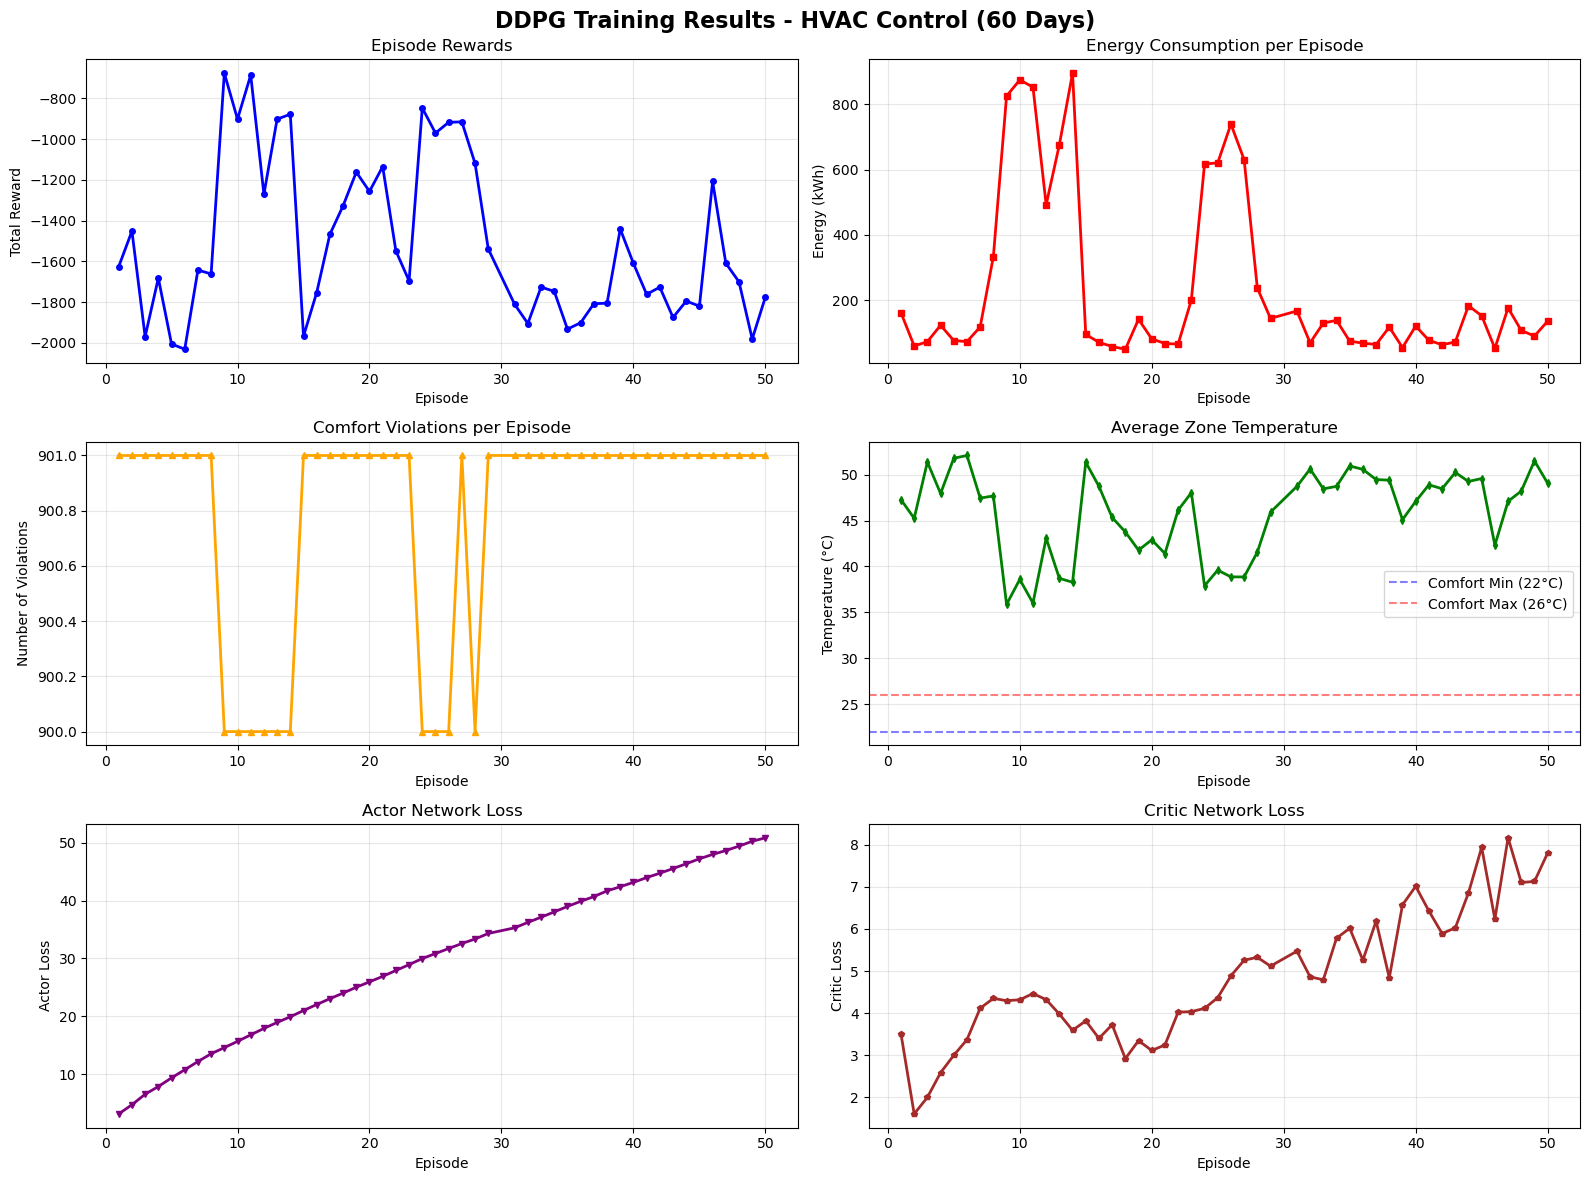


TRAINING SUMMARY
Best Reward: -675.61 (Ep 9)
Lowest Energy: 50.25 kWh (Ep 18)
Fewest Violations: 900 (Ep 9)
Final Reward: -1774.77
Final Energy: 136.21 kWh


In [ ]:
"""
Cell 8: Training Results Visualization
"""

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('DDPG Training Results - HVAC Control (60 Days)', fontsize=16, fontweight='bold')

# Episode Rewards
axes[0, 0].plot(training_history['episode'], training_history['episode_reward'], 
                linewidth=2, color='blue', marker='o', markersize=4)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].grid(True, alpha=0.3)

# Energy Consumption
axes[0, 1].plot(training_history['episode'], training_history['episode_energy'], 
                linewidth=2, color='red', marker='s', markersize=4)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Energy (kWh)')
axes[0, 1].set_title('Energy Consumption per Episode')
axes[0, 1].grid(True, alpha=0.3)

# Comfort Violations
axes[1, 0].plot(training_history['episode'], training_history['comfort_violations'], 
                linewidth=2, color='orange', marker='^', markersize=4)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Number of Violations')
axes[1, 0].set_title('Comfort Violations per Episode')
axes[1, 0].grid(True, alpha=0.3)

# Average Zone Temperature
axes[1, 1].plot(training_history['episode'], training_history['avg_T_zone'], 
                linewidth=2, color='green', marker='d', markersize=4)
axes[1, 1].axhline(y=22, color='b', linestyle='--', alpha=0.5, label='Comfort Min (22°C)')
axes[1, 1].axhline(y=26, color='r', linestyle='--', alpha=0.5, label='Comfort Max (26°C)')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].set_title('Average Zone Temperature')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Actor Loss
axes[2, 0].plot(training_history['episode'], training_history['actor_loss'], 
                linewidth=2, color='purple', marker='v', markersize=4)
axes[2, 0].set_xlabel('Episode')
axes[2, 0].set_ylabel('Actor Loss')
axes[2, 0].set_title('Actor Network Loss')
axes[2, 0].grid(True, alpha=0.3)

# Critic Loss
axes[2, 1].plot(training_history['episode'], training_history['critic_loss'], 
                linewidth=2, color='brown', marker='p', markersize=4)
axes[2, 1].set_xlabel('Episode')
axes[2, 1].set_ylabel('Critic Loss')
axes[2, 1].set_title('Critic Network Loss')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/training_results.png', dpi=300, bbox_inches='tight')
print("✓ Training visualization saved: ./results/training_results.png")
plt.show()

# Summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Best Reward: {max(training_history['episode_reward']):.2f} (Ep {training_history['episode'][np.argmax(training_history['episode_reward'])]})") 
print(f"Lowest Energy: {min(training_history['episode_energy']):.2f} kWh (Ep {training_history['episode'][np.argmin(training_history['episode_energy'])]})") 
print(f"Fewest Violations: {min(training_history['comfort_violations'])} (Ep {training_history['episode'][np.argmin(training_history['comfort_violations'])]})") 
print(f"Final Reward: {training_history['episode_reward'][-1]:.2f}")
print(f"Final Energy: {training_history['episode_energy'][-1]:.2f} kWh")
print("="*60)


In [ ]:
"""
Cell 9: Evaluation - Test trained policy
"""

print("="*60)
print("🧪 EVALUATING TRAINED POLICY")
print("="*60)

# Reset
state = env.reset()

# Collect evaluation actions
eval_states = []
eval_actions = []

print("\nCollecting evaluation actions (no noise)...")
n_eval_steps = CONFIG['simulation_days'] * 24

for step in range(n_eval_steps):
    eval_states.append(state.copy())
    
    # No exploration noise
    action = agent.policy(state, noise=False)
    eval_actions.append(action.copy())
    
    # Update state
    next_idx = min(step + 1, len(env.weather_df) - 1)
    next_weather = {
        'TDryBul': env.weather_df.loc[next_idx, 'TDryBul'],
        'relHum': env.weather_df.loc[next_idx, 'relHum']
    }
    
    hour_norm = ((step + 1) % 24) / 24.0
    day_norm = (((step + 1) // 24) % 7) / 7.0
    
    state = np.array([
        state[0], state[1], state[2],
        next_weather['TDryBul'] - 273.15,
        next_weather['relHum'] * 100,
        hour_norm, day_norm
    ], dtype=np.float32)
    
    if (step + 1) % 240 == 0:
        print(f"  {step+1}/{n_eval_steps} actions collected")

eval_actions = np.array(eval_actions)

# Run evaluation simulation
eval_results, eval_states, eval_rewards = env.run_episode_simulation(eval_actions)

if eval_results is not None:
    # Statistics
    T_zones = eval_results['T_zone'] - 273.15
    RH_zones = eval_results['RH_zone'] * 100
    CO2_zones = eval_results['CO2_zone']
    P_totals = eval_results['P_total']
    
    total_energy = np.trapz(P_totals, eval_results['time']) / 3600000
    violations = np.sum((T_zones < env.T_comfort_min) | 
                       (T_zones > env.T_comfort_max) |
                       (CO2_zones > env.CO2_limit))
    
    print(f"\n{'='*60}")
    print("EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Total Reward: {np.sum(eval_rewards):.2f}")
    print(f"Total Energy: {total_energy:.2f} kWh")
    print(f"Avg Power: {np.mean(P_totals)/1000:.2f} kW")
    print(f"Comfort Violations: {violations}/{len(T_zones)} ({100*violations/len(T_zones):.1f}%)")
    print(f"\nTemperature:")
    print(f"  Mean: {np.mean(T_zones):.2f}°C")
    print(f"  Range: {np.min(T_zones):.2f} - {np.max(T_zones):.2f}°C")
    print(f"  Std: {np.std(T_zones):.2f}°C")
    print(f"\nCO2:")
    print(f"  Mean: {np.mean(CO2_zones):.0f} ppm")
    print(f"  Max: {np.max(CO2_zones):.0f} ppm")
    print(f"  < 800 ppm: {100*np.sum(CO2_zones < 800)/len(CO2_zones):.1f}%")
    print(f"  > 1000 ppm: {100*np.sum(CO2_zones > 1000)/len(CO2_zones):.1f}%")
    print(f"\nControl Actions (mean):")
    print(f"  uOA: {np.mean(eval_actions[:len(eval_states), 0]):.3f}")
    print(f"  uChiller: {np.mean(eval_actions[:len(eval_states), 1]):.3f}")
    print(f"  uHeater: {np.mean(eval_actions[:len(eval_states), 2]):.3f}")
    print(f"  occupancy: {np.mean(eval_actions[:len(eval_states), 3]):.3f}")
    print(f"{'='*60}")
    
    # Save evaluation results
    eval_df = pd.DataFrame({
        'time_h': eval_results['time_hours'],
        'T_zone_C': T_zones,
        'RH_zone_%': RH_zones,
        'CO2_ppm': CO2_zones,
        'P_total_kW': P_totals / 1000,
        'uOA': eval_actions[:len(eval_states), 0],
        'uChiller': eval_actions[:len(eval_states), 1],
        'uHeater': eval_actions[:len(eval_states), 2],
        'occupancy': eval_actions[:len(eval_states), 3]
    })
    eval_df.to_csv('./results/evaluation_results.csv', index=False)
    print("\n✓ Evaluation saved: ./results/evaluation_results.csv")
else:
    print("✗ Evaluation failed")


🧪 EVALUATING TRAINED POLICY

  240/1440 actions collected
  480/1440 actions collected
  720/1440 actions collected
  960/1440 actions collected
  1200/1440 actions collected
  1440/1440 actions collected

🔄 Running FMU simulation (60 days)...
  Input shape: (1464, 13)
  ✓ FMU loaded: HVAC_FMU.AHU_FMU_Core_WeatherInput
Final Run Statistics: --- e+06

 Number of steps                                 : 80486
 Number of function evaluations                  : 122119
 Number of Jacobian evaluations                  : 1761
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 9849
 Number of nonlinear iterations                  : 122118
 Number of nonlinear convergence failures        : 490

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-05
 Tolerances (relative)    : 1e-05

Si

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3640\3505901503.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_energy = np.trapz(P_totals, eval_results['time']) / 3600000


AttributeError: 'HVACEnvironment' object has no attribute 'T_comfort_min'

✓ Evaluation visualization saved


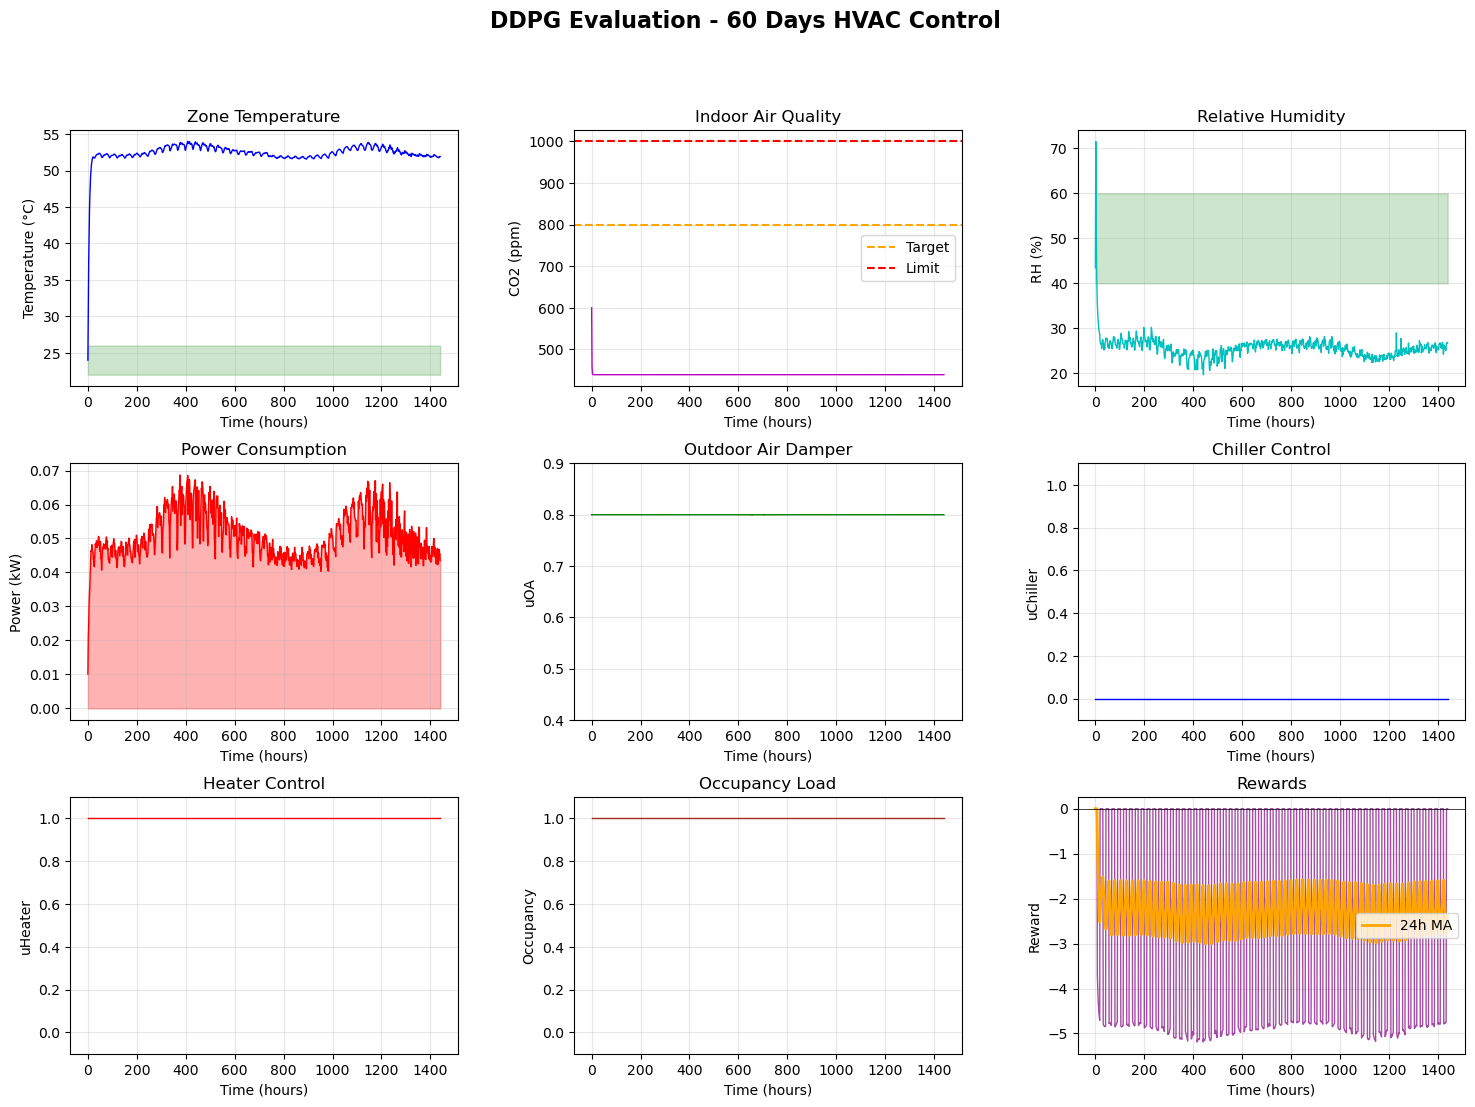


🎉 All done!


In [ ]:
"""
Cell 10: Evaluation Visualization
"""

if eval_results is not None:
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    time_hours = eval_results['time_hours']
    T_zones = eval_results['T_zone'] - 273.15
    RH_zones = eval_results['RH_zone'] * 100
    CO2_zones = eval_results['CO2_zone']
    P_totals = eval_results['P_total'] / 1000
    
    # Temperature
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time_hours, T_zones, 'b-', linewidth=1)
    ax1.fill_between(time_hours, 22, 26, alpha=0.2, color='green')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Zone Temperature')
    ax1.grid(True, alpha=0.3)
    
    # CO2
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(time_hours, CO2_zones, 'm-', linewidth=1)
    ax2.axhline(800, color='orange', linestyle='--', label='Target')
    ax2.axhline(1000, color='r', linestyle='--', label='Limit')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('CO2 (ppm)')
    ax2.set_title('Indoor Air Quality')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # RH
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(time_hours, RH_zones, 'c-', linewidth=1)
    ax3.fill_between(time_hours, 40, 60, alpha=0.2, color='green')
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('RH (%)')
    ax3.set_title('Relative Humidity')
    ax3.grid(True, alpha=0.3)
    
    # Power
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(time_hours, P_totals, 'r-', linewidth=1)
    ax4.fill_between(time_hours, 0, P_totals, alpha=0.3, color='red')
    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel('Power (kW)')
    ax4.set_title('Power Consumption')
    ax4.grid(True, alpha=0.3)
    
    # Control: uOA
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(time_hours, eval_actions[:len(time_hours), 0], 'g-', linewidth=1)
    ax5.set_xlabel('Time (hours)')
    ax5.set_ylabel('uOA')
    ax5.set_title('Outdoor Air Damper')
    ax5.set_ylim([0.4, 0.9])
    ax5.grid(True, alpha=0.3)
    
    # Control: uChiller
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(time_hours, eval_actions[:len(time_hours), 1], 'b-', linewidth=1)
    ax6.set_xlabel('Time (hours)')
    ax6.set_ylabel('uChiller')
    ax6.set_title('Chiller Control')
    ax6.set_ylim([-0.1, 1.1])
    ax6.grid(True, alpha=0.3)
    
    # Control: uHeater
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.plot(time_hours, eval_actions[:len(time_hours), 2], 'r-', linewidth=1)
    ax7.set_xlabel('Time (hours)')
    ax7.set_ylabel('uHeater')
    ax7.set_title('Heater Control')
    ax7.set_ylim([-0.1, 1.1])
    ax7.grid(True, alpha=0.3)
    
    # Control: occupancy
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.plot(time_hours, eval_actions[:len(time_hours), 3], 'brown', linewidth=1)
    ax8.set_xlabel('Time (hours)')
    ax8.set_ylabel('Occupancy')
    ax8.set_title('Occupancy Load')
    ax8.set_ylim([-0.1, 1.1])
    ax8.grid(True, alpha=0.3)
    
    # Rewards
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.plot(time_hours, eval_rewards[:len(time_hours)], 'purple', linewidth=1, alpha=0.7)
    rolling = pd.Series(eval_rewards[:len(time_hours)]).rolling(24, min_periods=1).mean()
    ax9.plot(time_hours, rolling, 'orange', linewidth=2, label='24h MA')
    ax9.axhline(0, color='k', linestyle='-', linewidth=0.5)
    ax9.set_xlabel('Time (hours)')
    ax9.set_ylabel('Reward')
    ax9.set_title('Rewards')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    fig.suptitle(f'DDPG Evaluation - {CONFIG["simulation_days"]} Days HVAC Control', 
                 fontsize=16, fontweight='bold')
    
    plt.savefig('./results/evaluation_visualization.png', dpi=300, bbox_inches='tight')
    print("✓ Evaluation visualization saved")
    plt.show()
    
    print("\n🎉 All done!")
else:
    print("Cannot create visualization - evaluation failed")
